# Step 0: Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load & Explore data

In [2]:
movies = pd.read_csv('./Data/movies.dat',
                         delimiter='::', engine='python', header=None, encoding='latin-1',
                         names=['movieId', 'title', 'genres'])

ratings = pd.read_csv('./Data/ratings.dat',
                         delimiter='::', engine='python', header=None, encoding='latin-1',
                         names=['userId', 'movieId', 'rating', 'timestamp'])



# Step 2: Drop Timestamp

In [3]:
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


# Step 3: Exploratory Analysis


## 3.1 Number of movies and users

In [4]:
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()
print(f'Number of unique movies: {n_movies}')
print(f'Number of unique users: {n_users}')

Number of unique movies: 3706
Number of unique users: 6040


## 3.2 Check Sparsity of the Data

In [5]:
available_ratings = ratings['rating'].count()
total_ratings = n_movies*n_users
missing_ratings = total_ratings - available_ratings
sparsity = (missing_ratings/total_ratings) * 100

print(f'Number of Available Raings: {available_ratings}')
print(f'Number of Missing Raings: {missing_ratings}')
print(f'Number of Total Raings: {total_ratings}', '\n')
print(f'Sparsity: {sparsity}')

Number of Available Raings: 1000209
Number of Missing Raings: 21384031
Number of Total Raings: 22384240 

Sparsity: 95.53163743776871


## 3.3 Explore the Distribution of Rating

<AxesSubplot:>

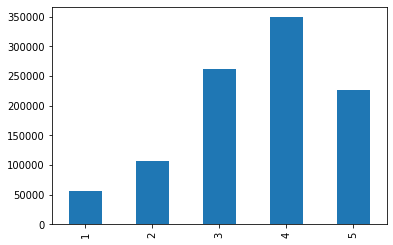

In [6]:
ratings['rating'].value_counts().sort_index().plot(kind='bar')

# Step 4: Dimensionality Reduction

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users

## 4.1 Filter movies with less than 3 ratings

In [7]:
filter_movies = ratings['movieId'].value_counts() > 3
filter_movies = filter_movies[filter_movies].index.tolist()
len(filter_movies)

3461

## 4.2 Filter users with less than 3 movies rated

In [8]:
filter_users = ratings['userId'].value_counts() > 3
filter_users = filter_users[filter_users].index.tolist()
len(filter_users)

6040

## 4.3 Remove rarely rated movies and rarely rating users

In [9]:
ratings = ratings[(ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))]
print(f'New shape: {ratings.shape}')

New shape: (999791, 3)


# Step 5: Create User Item Matrix

In [10]:
dataset = pd.merge(movies, ratings, how='left', on='movieId')


table = dataset.pivot_table(index='title', columns='userId', values='rating')

In [11]:
len(ratings.userId.unique()), len(ratings.movieId.unique())

(6040, 3461)

In [12]:
table.shape

(3461, 6040)

In [13]:
table = table.fillna(0)

In [14]:
table.head(2)

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Night Mother (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [15]:
from scipy.sparse import csr_matrix

matrix = csr_matrix(table.values)

In [16]:
user_query_index = np.random.choice(table.shape[1])
user_query_index

3264

In [17]:
from sklearn.metrics.pairwise import linear_kernel

cosine = linear_kernel(matrix, matrix)

# Step 6: Normal Recommendation based on the Cosine Similarity Matrix

In [18]:
def recommendations(name, cosine = cosine):
    recommended_list = []
    idx = user_query_index
    score = pd.Series(cosine[idx]).sort_values(ascending=False)
    
    top_10 = list(score.iloc[0:11].index)
    for each in top_10:
        recommended_list.append(list(table.index)[each])
    return recommended_list

print('Recommendation for {0} :\n'.format(table.index[user_query_index]))
recommendations(table.index[user_query_index])

Recommendation for Unhook the Stars (1996) :



['Fargo (1996)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'American Beauty (1999)',
 "Schindler's List (1993)",
 'Crying Game, The (1992)',
 'Pulp Fiction (1994)',
 'Godfather, The (1972)',
 'Player, The (1992)',
 'Quiz Show (1994)',
 'Big Night (1996)']

In [19]:
dataset = dataset.fillna(0)

# Step 7: Movies rated by a user with User ID = 1

In [20]:
dataset.loc[dataset['userId'] == 1]

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1.0,5.0
22893,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1.0,5.0
41540,150,Apollo 13 (1995),Drama,1.0,5.0
67445,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1.0,4.0
141662,527,Schindler's List (1993),Drama|War,1.0,5.0
144755,531,"Secret Garden, The (1993)",Children's|Drama,1.0,4.0
158456,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1.0,4.0
167917,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,1.0,4.0
168680,595,Beauty and the Beast (1991),Animation|Children's|Musical,1.0,5.0
172007,608,Fargo (1996),Crime|Drama|Thriller,1.0,4.0


# Step 8: Predicting a user's rating

In [21]:
from surprise import SVD, Reader, Dataset
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import linear_kernel

In [22]:
svd = SVD()
reader = Reader()
cosine = linear_kernel(matrix, matrix)

In [23]:
df = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)

In [24]:
#cross_validate(svd, df, measures=['RMSE', 'MAE'], cv = 5, verbose= True)
cross_validate(svd, df, measures=['RMSE', 'MSE'], cv = 5, verbose= True)

Evaluating RMSE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8738  0.8720  0.8729  0.8774  0.8724  0.8737  0.0020  
MSE (testset)     0.7636  0.7603  0.7619  0.7699  0.7610  0.7633  0.0035  
Fit time          8.31    8.65    7.94    7.76    7.72    8.07    0.36    
Test time         1.78    1.53    1.61    1.58    1.62    1.62    0.08    


{'test_rmse': array([0.87382726, 0.87196825, 0.87285945, 0.87743563, 0.87236902]),
 'test_mse': array([0.76357408, 0.76032862, 0.76188362, 0.76989329, 0.7610277 ]),
 'fit_time': (8.312864303588867,
  8.646939754486084,
  7.936780691146851,
  7.755739688873291,
  7.7170305252075195),
 'test_time': (1.7763981819152832,
  1.5263426303863525,
  1.6123614311218262,
  1.5753529071807861,
  1.6233644485473633)}

In [25]:
trainset = df.build_full_trainset()
svd.fit(trainset)

     Prediciting the rating of userId 1 for the movieId = user_query_index

In [26]:
svd.predict(1, 226, 3)

Prediction(uid=1, iid=226, r_ui=3, est=3.817908122032638, details={'was_impossible': False})

In [27]:
svd.predict(1, 829, 3)

Prediction(uid=1, iid=829, r_ui=3, est=2.3971068030432656, details={'was_impossible': False})

In [28]:
svd.predict(1, 879, 3)

Prediction(uid=1, iid=879, r_ui=3, est=2.8369685406439658, details={'was_impossible': False})

In [29]:
svd.predict(1, 923, 3)

Prediction(uid=1, iid=923, r_ui=3, est=4.601245622689121, details={'was_impossible': False})

In [30]:
svd.predict(1, 1043, 3)

Prediction(uid=1, iid=1043, r_ui=3, est=3.0197048228603625, details={'was_impossible': False})

In [31]:
svd.predict(1, 1413, 3)

Prediction(uid=1, iid=1413, r_ui=3, est=3.6611547836459257, details={'was_impossible': False})

In [32]:
svd.predict(1, 1820, 3)

Prediction(uid=1, iid=1820, r_ui=3, est=3.6781190845005103, details={'was_impossible': False})

In [33]:
svd.predict(1, 2412, 3)

Prediction(uid=1, iid=2412, r_ui=3, est=2.7984437411584517, details={'was_impossible': False})

In [34]:
svd.predict(1, 2711, 3)

Prediction(uid=1, iid=2711, r_ui=3, est=3.5518455995723968, details={'was_impossible': False})